# PyCS Tutorial

In this notebook we work through the `PyCS` "demo1" tutorial, to show how the `PyCS` package enables the estimation of a lens time delay from example light curve data. The original tutorial is in the form of a set of 6 scripts, that can be viewed on the `PyCS` website [here](http://pycs.readthedocs.io/en/latest/tutorial/demo1.html). The demo1 code itself can be browsed in the `PyCS` GitHub repository [here](https://github.com/COSMOGRAIL/PyCS/tree/master/demo/demo1).

## 1. Obtaining PyCS and its Sample Data 

The "demo1" tutorial uses a 4-image light curve dataset that comes with the `PyCS` repository. Let's download this and use `PyCS` to analyze it. If you haven't yet followed the [`SLTimer` installation instructions](https://github.com/DarkEnergyScienceCollaboration/SLTimer/blob/master/INSTALL.md) you should do that before attempting to `import pycs`. 

In [16]:
import os, urllib
from __future__ import print_function
import pycs
import numpy as np
import corner
from matplotlib import pyplot as plt
%matplotlib inline

We need to grab `rdbfile` (the demo1 dataset) from `webdir` (the appropriate `PyCS` GitHub folder). We only need to download `rdbfile` if it doesn't already exist.

In [3]:
webdir = 'https://raw.githubusercontent.com/COSMOGRAIL/PyCS/master/demo/demo1/data/'
rdbfile = 'trialcurves.txt'
    
url = os.path.join(webdir, rdbfile)
if not os.path.isfile(rdbfile):
    urllib.urlretrieve(url, rdbfile)
    
!wc -l $rdbfile

     194 trialcurves.txt


## 2. Displaying the Light Curve Data

First lets read in the data from the rdbfile, in this case from a simple text file with a one-line header. (Other formats are supported as well.)

In [4]:
lcs = [
        pycs.gen.lc.rdbimport(rdbfile, 'A', 'mag_A', 'magerr_A', "Trial"),
        pycs.gen.lc.rdbimport(rdbfile, 'B', 'mag_B', 'magerr_B', "Trial"),
        pycs.gen.lc.rdbimport(rdbfile, 'C', 'mag_C', 'magerr_C', "Trial"),
        pycs.gen.lc.rdbimport(rdbfile, 'D', 'mag_D', 'magerr_D', "Trial")
]

Checking header of "trialcurves.txt"...
Reading "trialcurves.txt"...
[Trial/A] with 192 points imported (0 of them masked).
Checking header of "trialcurves.txt"...
Reading "trialcurves.txt"...
[Trial/B] with 192 points imported (0 of them masked).
Checking header of "trialcurves.txt"...
Reading "trialcurves.txt"...
[Trial/C] with 192 points imported (0 of them masked).
Checking header of "trialcurves.txt"...
Reading "trialcurves.txt"...
[Trial/D] with 192 points imported (0 of them masked).


In [5]:
pycs.gen.mrg.colourise(lcs) 

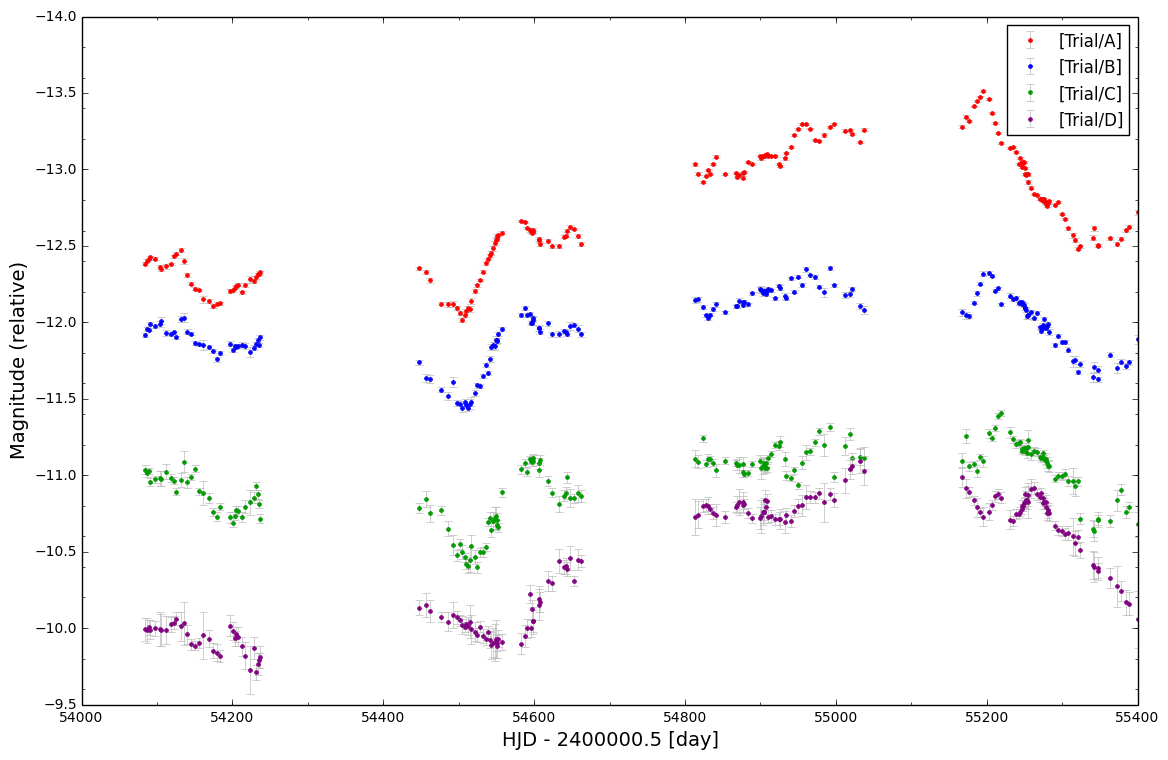

In [6]:
pycs.gen.lc.display(lcs)

In [12]:
 def spl(lcs):
    spline = pycs.spl.topopt.opt_rough(lcs, nit=5, knotstep=50,verbose=False)
    spline = pycs.spl.topopt.opt_rough(lcs, nit=5, knotstep=30,verbose=False)
    spline = pycs.spl.topopt.opt_fine(lcs, nit=10, knotstep=20,verbose=False)
    return spline

In [8]:
for l in lcs:
    pycs.gen.splml.addtolc(l,knotstep=150)

Let's re-optimize and see what happens to the time delays:

In [13]:
spline = spl(lcs)

Starting ML optimization ...
Working on the spline ML of [Trial/A](-1.154,0.000,0)|~3/12l12b/7~|
Working on the spline ML of [Trial/B](-5.779,-0.647,0)|~3/12l12b/7~|
Working on the spline ML of [Trial/C](-21.983,-1.603,0)|~3/12l12b/7~|
Working on the spline ML of [Trial/D](-69.167,-2.092,0)|~3/12l12b/7~|
Done !
Starting ML optimization ...
Working on the spline ML of [Trial/A](-1.154,0.000,0)|~3/12l12b/7~|
Working on the spline ML of [Trial/B](-6.779,-0.647,0)|~3/12l12b/7~|
Working on the spline ML of [Trial/C](-20.983,-1.603,0)|~3/12l12b/7~|
Working on the spline ML of [Trial/D](-83.167,-2.092,0)|~3/12l12b/7~|
Done !


In [14]:
spline_microlensing_time_delays = pycs.gen.lc.getnicetimedelays(lcs, separator="\n", sorted=True)
print("Time Delays (microlensing included, with splines):")
print(spline_microlensing_time_delays)

Time Delays (microlensing included, with splines):
AB   -4.64
AC  -21.01
AD  -68.66
BC  -16.38
BD  -64.03
CD  -47.65


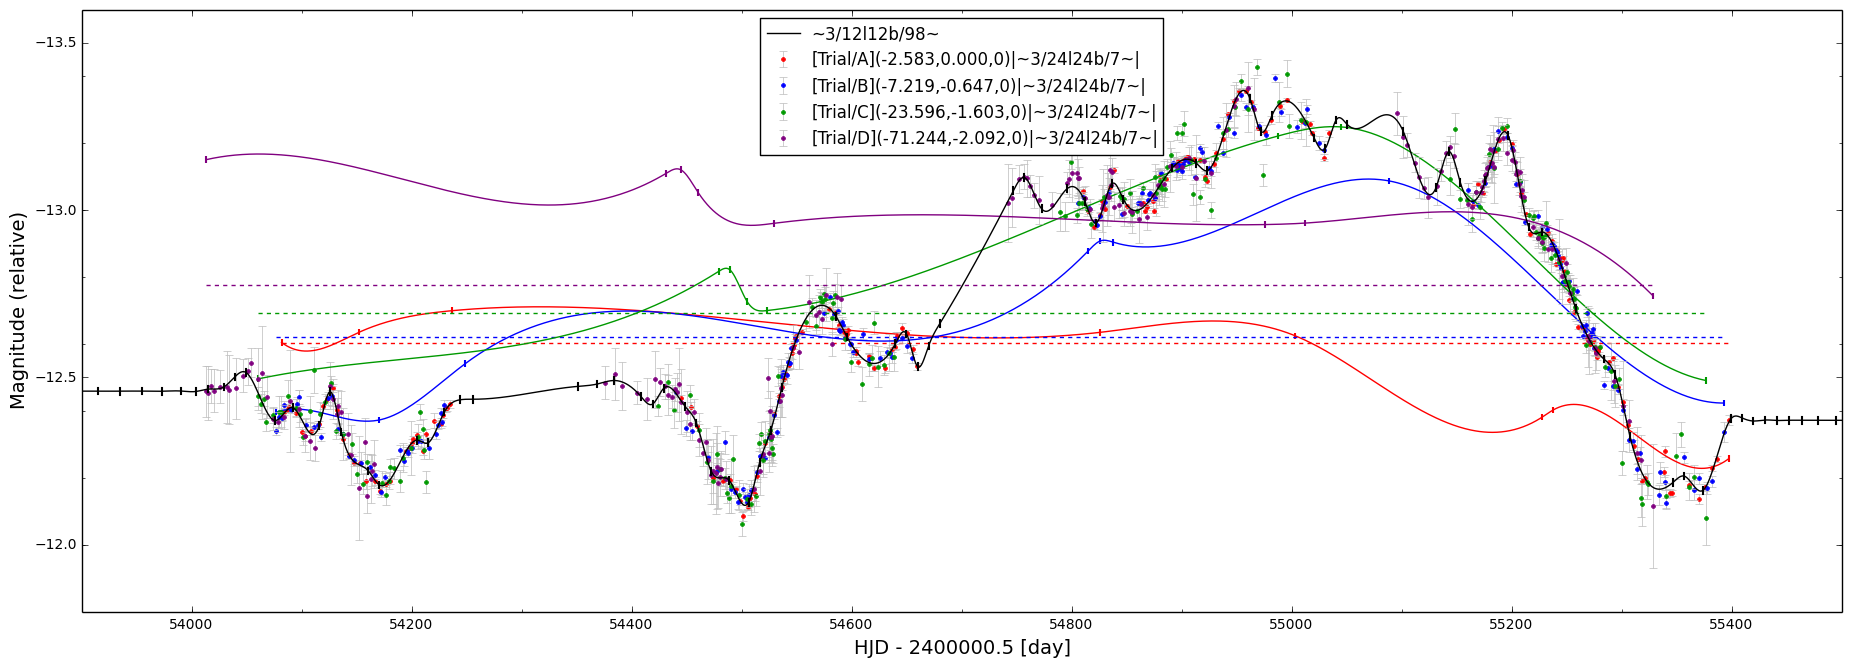

In [15]:
pycs.gen.lc.display(lcs, [spline], knotsize=0.01, figsize=(20, 7), jdrange=(53900, 55500))

In [49]:
ndim, nsamples = 3, 10
sample=np.random.rand(ndim*nsamples).reshape(nsamples,ndim)*200-100

CPU times: user 3 µs, sys: 5 µs, total: 8 µs
Wall time: 31.9 µs


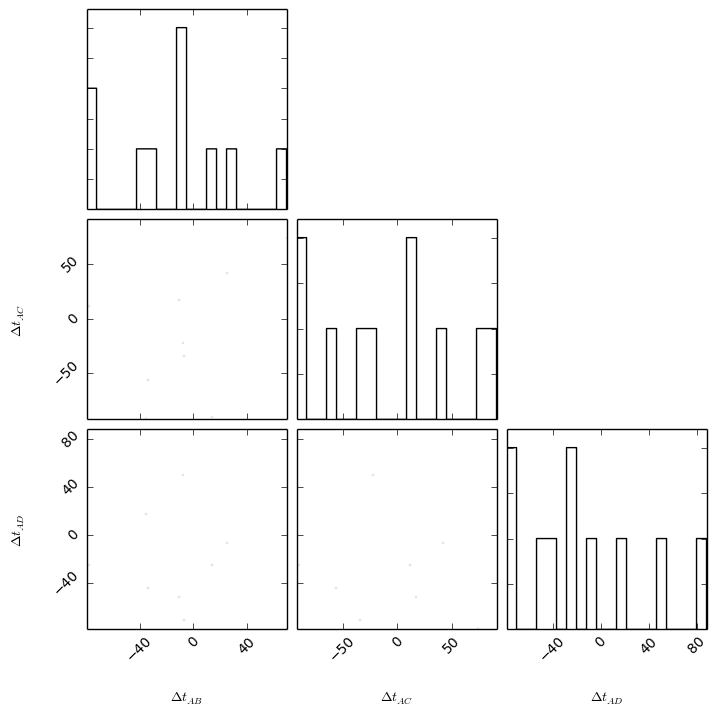

In [50]:
%time
fig=corner.corner(sample,labels=[r'$\Delta t_{AB}$',r'$\Delta t_{AC}$',r'$\Delta t_{AD}$'],
                  levels=[0.30,0.40],plot_contours=False,plot_density=False)

In [51]:
def getWeight(delay):
    for l in lcs:
        l.resetshifts()
        l.resetml()
    for index, l in enumerate(lcs):
        pycs.gen.splml.addtolc(l,knotstep=150)
        if index!=0:
            l.timeshift=delay[index-1]
    spline = spl(lcs)
    return np.exp(-0.5*spline.lastr2nostab)

In [52]:
%%time
weight=[]
for delay in sample:
    print(delay)
    weight.append(getWeight(delay))

[-35.58563756 -92.18180205  17.75142045]
Starting ML optimization ...
Working on the spline ML of [Trial/A]|~3/u/7~|
Working on the spline ML of [Trial/B](-35.586,-0.647,0)|~3/u/7~|
Working on the spline ML of [Trial/C](-92.182,-1.603,0)|~3/u/7~|
Working on the spline ML of [Trial/D](17.751,-2.092,0)|~3/u/7~|
Done !
Starting ML optimization ...
Working on the spline ML of [Trial/A](-5.000,0.000,0)|~3/u/7~|
Working on the spline ML of [Trial/B](-21.586,-0.647,0)|~3/u/7~|
Working on the spline ML of [Trial/C](-37.182,-1.603,0)|~3/u/7~|
Working on the spline ML of [Trial/D](-8.249,-2.092,0)|~3/u/7~|
Done !
[-79.64286387  90.79275306  88.22088706]
Starting ML optimization ...
Working on the spline ML of [Trial/A]|~3/u/7~|
Working on the spline ML of [Trial/B](-79.643,-0.647,0)|~3/u/7~|
Working on the spline ML of [Trial/C](90.793,-1.603,0)|~3/u/7~|
Working on the spline ML of [Trial/D](88.221,-2.092,0)|~3/u/7~|
Done !
Starting ML optimization ...
Working on the spline ML of [Trial/A](1.000

In [85]:
print(lcs[0].ml)

|~3/u/7~|


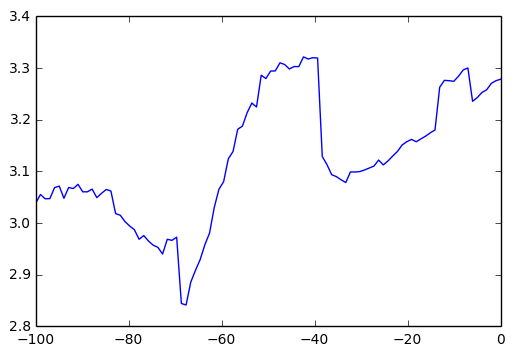

In [101]:
plt.plot(timeshifts,residual)

## 4. Estimating the Time Delay Uncertainties

Error estimation with `PyCS` is performed by re-sampling the data, re-optimizing the model, and accumulating statistics about the resulting time delays. 

To evaluate the intrinsic variance of the optimizer, we make `Ncopies` copies of the dataset, and re-optimize the model for each one. To probe the width of the likelihood function itself, we generate and use `Nmocks` synthetic datasets, with slightly different time delays. For the latter step, we need to read in an optimized model and its shifted light curves. In each case we'll need to collect together the many optimized light curves' time delays at the end, and compute some statistics.

First, though, we need to clear out any previous simulations we did, because `PyCS` works on all files in a simulation folder, and we don't want to mix up any old files with new ones.

In [33]:
!\rm -rfv sims_copies sims_mocks
!\rm -rfv sims_copies_opt_spl sims_copies_opt_disp sims_copies_opt_regdiff
!\rm -rfv sims_mocks_opt_spl sims_mocks_opt_disp sims_mocks_opt_regdiff

sims_copies/1_1475037895.44316.pkl
sims_copies/2_1475037895.45255.pkl
sims_copies/3_1475037895.45869.pkl
sims_copies/4_1475037895.46449.pkl
sims_copies
sims_mocks/1_1475037895.51862.pkl
sims_mocks/2_1475037895.65321.pkl
sims_mocks/3_1475037895.75946.pkl
sims_mocks/4_1475037895.83591.pkl
sims_mocks
sims_copies_opt_spl/1_1475037895.44316_opt.pkl
sims_copies_opt_spl/1_1475037895.44316_runresults.pkl
sims_copies_opt_spl/2_1475037895.45255_opt.pkl
sims_copies_opt_spl/2_1475037895.45255_runresults.pkl
sims_copies_opt_spl/3_1475037895.45869_opt.pkl
sims_copies_opt_spl/3_1475037895.45869_runresults.pkl
sims_copies_opt_spl/4_1475037895.46449_opt.pkl
sims_copies_opt_spl/4_1475037895.46449_runresults.pkl
sims_copies_opt_spl
sims_copies_opt_disp/1_1475037895.44316_runresults.pkl
sims_copies_opt_disp/2_1475037895.45255_runresults.pkl
sims_copies_opt_disp/3_1475037895.45869_runresults.pkl
sims_copies_opt_disp/4_1475037895.46449_runresults.pkl
sims_copies_opt_disp
sims_copies_opt_regdiff/1_1475037895

### 4.1  Re-sampling the Light Curve Data

First, the plain copies:

In [34]:
n, npkl = 1, 4
Ncopies = n*npkl
print("Making",Ncopies,"copies of the original dataset:")
pycs.sim.draw.multidraw(lcs, onlycopy=True, n=n, npkl=npkl, simset="copies")

Making 4 copies of the original dataset:
Now thowing dice into sims_copies ...
Input shifts :
A    -5.70 | B   -10.46 | C   -26.38 | D   -74.17
Input delays :
AB   -4.76 | AC  -20.68 | AD  -68.47 | BC  -15.92 | BD  -63.71 | CD  -47.79
Preparing 1 identical copies for pkl 1/4 ...
Wrote sims_copies/1_1475093439.64908.pkl
Preparing 1 identical copies for pkl 2/4 ...
Wrote sims_copies/2_1475093439.65691.pkl
Preparing 1 identical copies for pkl 3/4 ...
Wrote sims_copies/3_1475093439.66198.pkl
Preparing 1 identical copies for pkl 4/4 ...
Wrote sims_copies/4_1475093439.66685.pkl


Now the synthetic light curves:

In [35]:
(modellcs, modelspline)  = pycs.gen.util.readpickle("optspline.pkl")

Read optspline.pkl


We want each synthetic light curve to have slightly different underlying microlensing signals as well as a slightly different set of time delays. This is achieved via a set of "tweak" functions, that implement some small scale extrinsic variability when we generate the synthetic curves. Note that the control parameters `beta`, `sigma`, and `fmin` have to be *asserted*, these values can be changed. 

In [36]:
def Atweakml(lcs):
    return pycs.sim.twk.tweakml(lcs, beta=-1.5, sigma=0.25, fmin=1/500.0, fmax=None, psplot=False)

def Btweakml(lcs):
    return pycs.sim.twk.tweakml(lcs, beta=-1.0, sigma=0.9, fmin=1/500.0, fmax=None, psplot=False)

def Ctweakml(lcs):
    return pycs.sim.twk.tweakml(lcs, beta=-1.0, sigma=1.5, fmin=1/500.0, fmax=None, psplot=False)

def Dtweakml(lcs):
    return pycs.sim.twk.tweakml(lcs, beta=-0.0, sigma=4.5, fmin=1/500.0, fmax=None, psplot=False)

At this place, *only* if you know what you are doing, you can manually adjust the microlensing or the delays. If not, run this script. This will run `n` simulations for each element in the pickle file. 

In [37]:
n, npkl = 1, 4
Nmocks = n*npkl
truetsr = 8.0
print("Making",Nmocks,"synthetic datasets, varying time delays by +/-",truetsr/2.0,"days")
pycs.sim.draw.saveresiduals(modellcs, modelspline)
pycs.sim.draw.multidraw(modellcs, modelspline, n=n, npkl=npkl, simset="mocks",
        truetsr=truetsr, tweakml=[Atweakml, Btweakml, Ctweakml, Dtweakml])

Making 4 synthetic datasets, varying time delays by +/- 4.0 days
Now thowing dice into sims_mocks ...
Input shifts :
A    -5.70 | B   -10.46 | C   -26.38 | D   -74.17
Input delays :
AB   -4.76 | AC  -20.68 | AD  -68.47 | BC  -15.92 | BD  -63.71 | CD  -47.79
Drawing 1 simulations for pkl 1/4 ...
Wrote sims_mocks/1_1475093439.70907.pkl
Drawing 1 simulations for pkl 2/4 ...
Wrote sims_mocks/2_1475093439.78239.pkl
Drawing 1 simulations for pkl 3/4 ...
Wrote sims_mocks/3_1475093439.86694.pkl
Drawing 1 simulations for pkl 4/4 ...
Wrote sims_mocks/4_1475093439.92795.pkl


Note that we chose the name of our set of synthetic light curves "1Kset1" via the `simset` kwarg. "truetsr=8.0" means that the synthetic curves will get random true time shifts in a range of about 8.0 days around the time shifts of the model `lcs` objects. 

### 4.2 Re-running the Model Fits

Now, we will run the free-knot spline technique using the plain copies we made earlier of the data. This will take a while: we're doing `Ncopies` separate model optimizations.

In [38]:
pycs.sim.run.multirun("copies", lcs, spl, optset="spl", tsrand=10.0, keepopt=True)

I have found 4 simulation pickles in sims_copies.
I'll write my results into the directory sims_copies_opt_spl.
Initial conditions : 
[Trial/A](-5.704,0.000,0)|~3/12l12b/7~|
[Trial/B](-10.462,-0.647,0)|~3/12l12b/7~|
[Trial/C](-26.383,-1.603,0)|~3/12l12b/7~|
[Trial/D](-74.171,-2.092,0)|~3/12l12b/7~|
--- Casino running on simset copies, optset spl ---
Read sims_copies/1_1475093439.64908.pkl
Working for sims_copies_opt_spl/1_1475093439.64908_runresults.pkl, 1 simulations.
Starting the curve shifting on a single CPU, no multiprocessing...
Starting opt_rough on initial delays :
BD  -45.25 | BC   -4.23 | BA  +12.52 | DC  +41.03 | DA  +57.77 | CA  +16.75
Aiming at first curve.
Starting ML optimization ...
Working on the spline ML of [Trial/B](-19.380,-0.647,0)|~3/12l12b/7~|
Working on the spline ML of [Trial/D](-64.633,-2.092,0)|~3/12l12b/7~|
Working on the spline ML of [Trial/C](-23.606,-1.603,0)|~3/12l12b/7~|
Working on the spline ML of [Trial/A](-6.859,0.000,0)|~3/12l12b/7~|
Done !
First s

Now, we will run the free-knot spline technique on each of the `Nmocks` synthetic light curve datasets we made earlier - again, this will take a while. Note the `keepopt=True` kwarg: this will make it easier to read the residuals from the synthetic curves with the residuals from the observed data. You can change the name "optset" to anything, though it should best reflect the name of the full method, including the settings of the microlensing. 

In [39]:
tsrand = 1.0
pycs.sim.run.multirun("mocks", lcs, spl, optset="spl", tsrand=tsrand, keepopt=True)

I have found 4 simulation pickles in sims_mocks.
I'll write my results into the directory sims_mocks_opt_spl.
Initial conditions : 
[Trial/A](-5.704,0.000,0)|~3/12l12b/7~|
[Trial/B](-10.462,-0.647,0)|~3/12l12b/7~|
[Trial/C](-26.383,-1.603,0)|~3/12l12b/7~|
[Trial/D](-74.171,-2.092,0)|~3/12l12b/7~|
--- Casino running on simset mocks, optset spl ---
Read sims_mocks/1_1475093439.70907.pkl
Working for sims_mocks_opt_spl/1_1475093439.70907_runresults.pkl, 1 simulations.
Starting the curve shifting on a single CPU, no multiprocessing...
Starting opt_rough on initial delays :
DC  +46.56 | DB  +63.35 | DA  +68.02 | CB  +16.80 | CA  +21.46 | BA   +4.67
Aiming at first curve.
Starting ML optimization ...
Working on the spline ML of [Trialsim/D](-73.427,-2.092,0)|~3/12l12b/7~|
Working on the spline ML of [Trialsim/C](-26.870,-1.686,0)|~3/12l12b/7~|
Working on the spline ML of [Trialsim/B](-10.074,-0.687,0)|~3/12l12b/7~|
Working on the spline ML of [Trialsim/A](-5.406,-0.060,0)|~3/12l12b/7~|
Done !

> Note: The two lines of code above do not (always) run, possibly due to a bug that should be reported to PyCS. Here is the resulting error message. 
>
> `RuntimeError: Knot spacing min = 7.283257, epsilon = 10.000000`

### 4.3 Collecting the Outputs



First, let's get the results from the copies of the observed light curves. 

In [40]:
dataresults = [
        pycs.sim.run.collect("sims_copies_opt_spl", "blue", "Free-knot spline technique")
]

Reading 4 runresult pickles...
OK, I have collected 4 runs from Free-knot spline technique


Now, we can turn this into a simple histogram that will give the instrinic variance. It will be saved to a file called "fig_instrinsicvariance.pdf", for readability. The option `dataout=True` will save the delay point estimate, to be used below. 

Wrote sims_copies_opt_spl_delays.pkl
Plotting "Free-knot spline technique (Measured, 4) "
     Labels : A, B, C, D
     Median shifts : -9.39, -14.39, -30.53, -78.54
     Std shifts : 2.24, 2.15, 1.96, 1.91


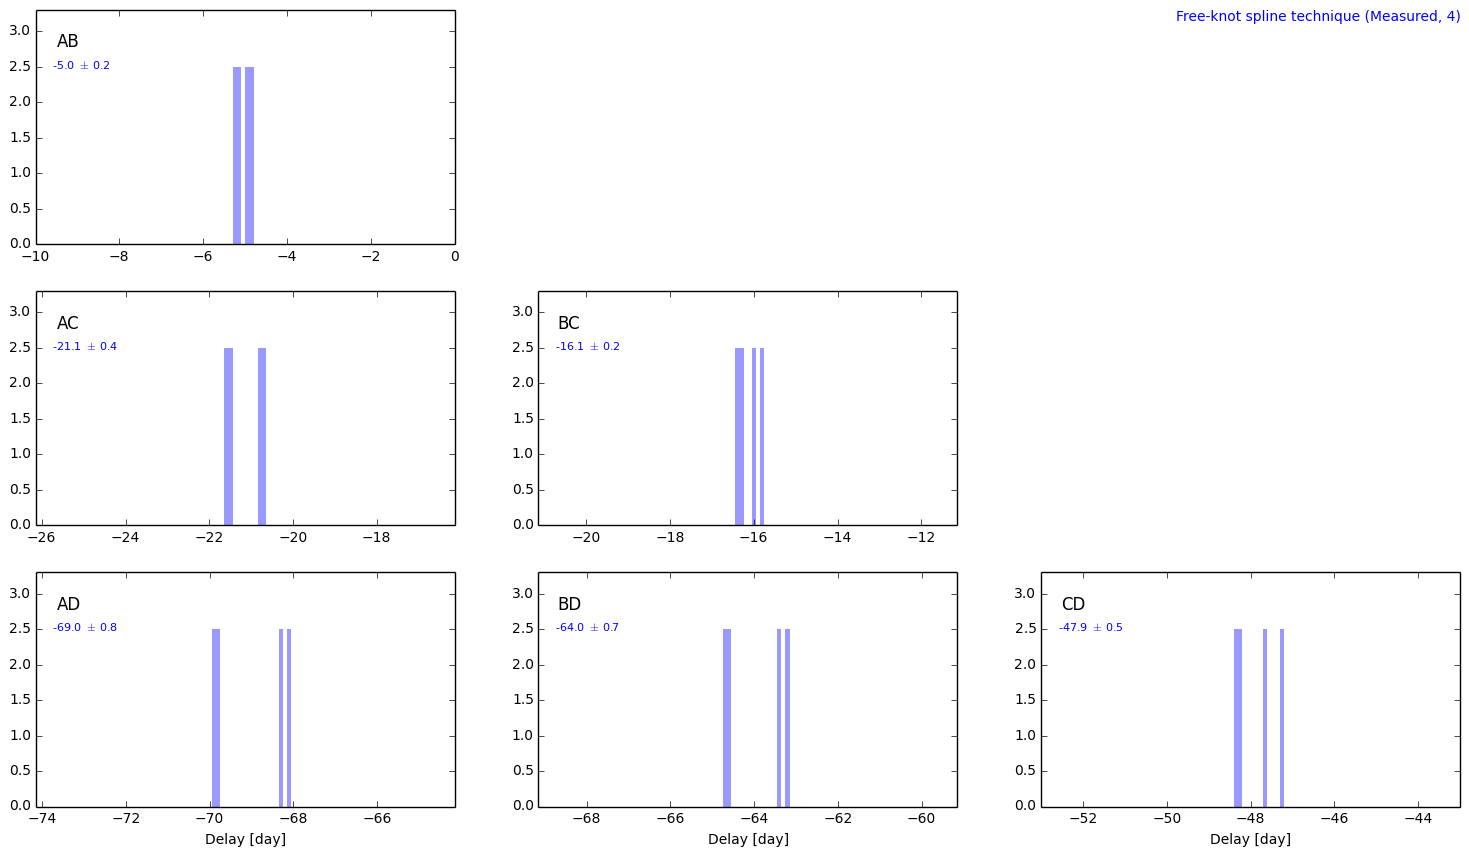

In [41]:
pycs.sim.plot.hists(dataresults, r=5.0, nbins=100, showqs=False,
        filename="fig_intrinsicvariance.pdf", dataout=True)

We read the results obtained on the synthetic curves. 

In [42]:
simresults = [
        pycs.sim.run.collect("sims_mocks_opt_spl", "blue", "Free-knot spline technique")
]

Reading 4 runresult pickles...
OK, I have collected 4 runs from Free-knot spline technique


Now we can perform the error analysis. This will be saved to a file called "fig_measvstrue.pdf". The option `dataout=True` will save the random and systematic error, to be used below.

Wrote sims_mocks_opt_spl_errorbars.pkl


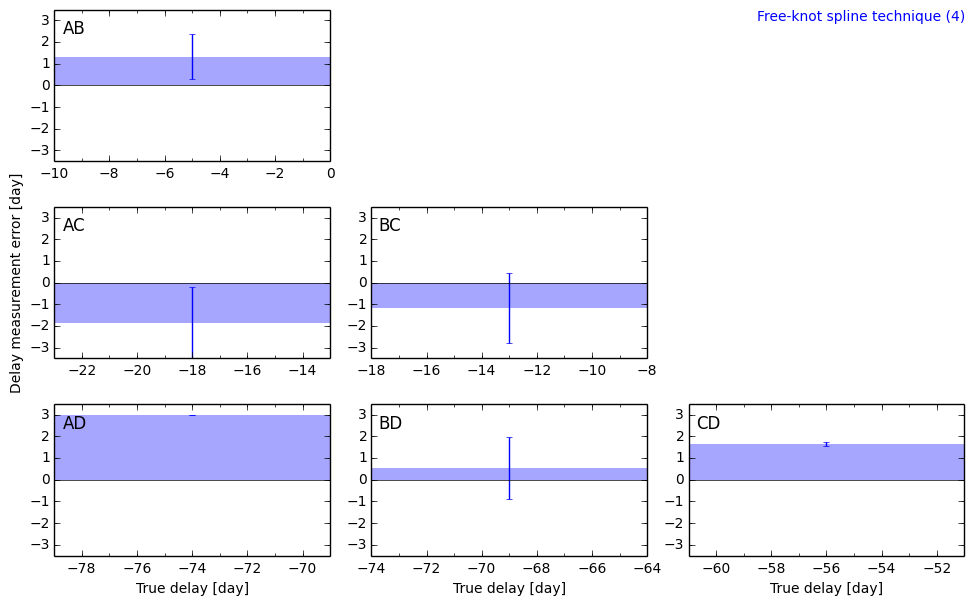

In [43]:
pycs.sim.plot.measvstrue(simresults, errorrange=3.5, r=5.0, nbins = 1, binclip=True, binclipr=20.0,
        plotpoints=False, filename="fig_measvstrue.pdf", dataout=True)

With the same data we can also show the relationship between measurements. This will be written to a file called "fig_covplot.pdf".

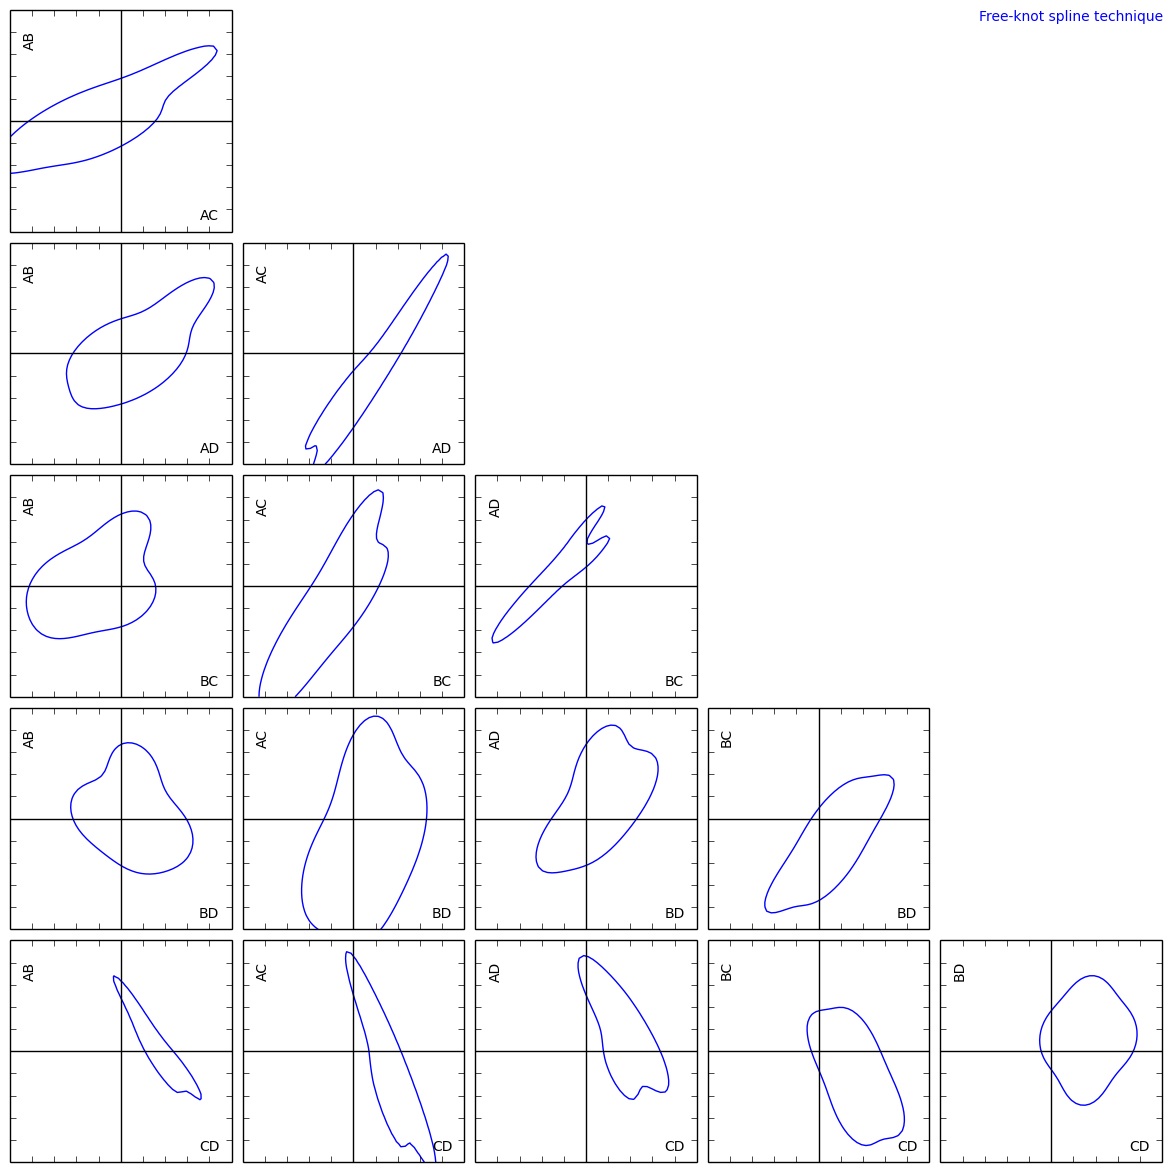

In [44]:
pycs.sim.plot.covplot(simresults, filename="fig_covplot.pdf")

Finally we group the information saved by these steps to get the results in form of a summary plot. Let's define our variables. 

In [45]:
dataresults = [(pycs.gen.util.readpickle("sims_copies_opt_spl_delays.pkl"),
               pycs.gen.util.readpickle("sims_mocks_opt_spl_errorbars.pkl"))]

Read sims_copies_opt_spl_delays.pkl
Read sims_mocks_opt_spl_errorbars.pkl


Now we can display our plot! It will be saved to a file called "fig_delays.pdf".

Objects : A, B, C, D
Delays : Free-knot spline technique <-> Errors : Free-knot spline technique
################################################################################
           Delay AB
                   Free-knot spline technique :  -5.03 +/- 1.69 (1.04, 1.33)
################################################################################
           Delay AC
                   Free-knot spline technique : -21.14 +/- 2.48 (1.64, 1.85)
################################################################################
           Delay BC
                   Free-knot spline technique : -16.10 +/- 2.01 (1.63, 1.18)
################################################################################
           Delay AD
                   Free-knot spline technique : -69.03 +/- 2.97 (0.00, 2.97)
################################################################################
           Delay BD
                   Free-knot spline technique : -64.00 +/- 1.51 (1.42, 0.53)
#############

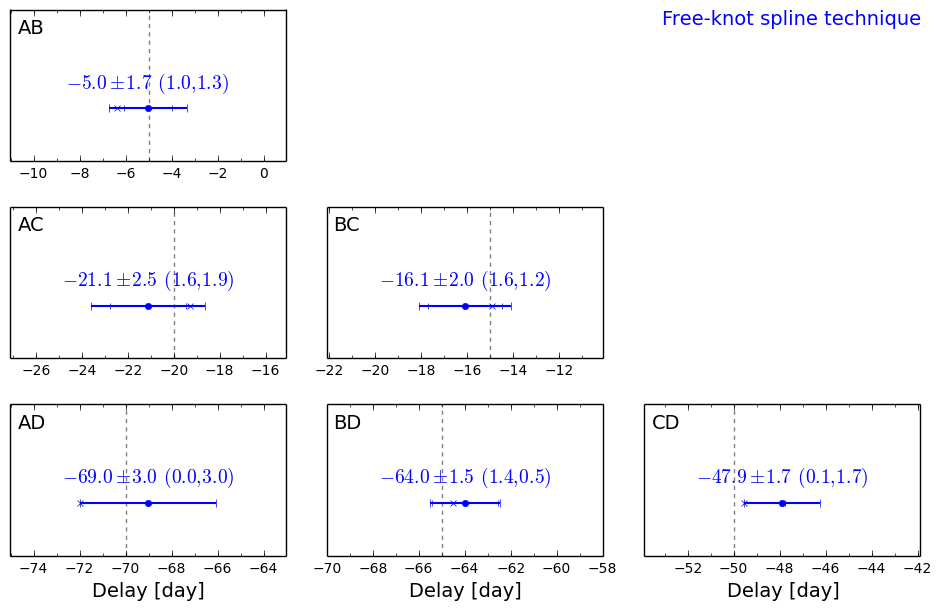

In [46]:
pycs.sim.plot.newdelayplot(dataresults, rplot=6.0, displaytext=True,
        filename = "fig_delays.pdf", refshifts=[{"colour":"gray", "shifts":(0, -5, -20, -70)}])

## 5. Comparing Different Curve-shifting Techniques

`PyCS` supports a number of different time delay estimation methods, as well as the free-knot spline curve-shifting model. Let's try a couple more of them now, and compare with the spline model (which we already optimized and explored). We'll start the other two the same way, on the original data and with a reasonable set of guessed initial shifts, for a fair comparison.

In [47]:
import pycs.regdiff

for l in lcs:
    l.resetshifts()
    
lcs[1].shifttime(-7.0)
lcs[2].shifttime(-22.0)
lcs[3].shifttime(-65.0)

print(pycs.gen.lc.getnicetimedelays(lcs, separator="\n", sorted=True))

def regdiff(lcs):
    return pycs.regdiff.multiopt.opt_ts(lcs, pd=5, scale=200.0, verbose=True)
def disp(lcs):
    return pycs.disp.topopt.opt_full(lcs, rawdispersionmethod, nit=5, verbose=True)

AB   -7.00
AC  -22.00
AD  -65.00
BC  -15.00
BD  -58.00
CD  -43.00


### 5.1 Dispersion Method

Our second technique will be the dispersion technique. First, let's run the code needed to define our variables. 

In [48]:
rawdispersionmethod = lambda lc1, lc2 : pycs.disp.disps.linintnp(lc1, lc2, interpdist = 30.0)
dispersionmethod = lambda lc1, lc2 : pycs.disp.disps.symmetrize(lc1, lc2, rawdispersionmethod)

Next, let's factor in our microlensing models (polynomials). 

In [49]:
pycs.gen.polyml.addtolc(lcs[0], nparams=2, autoseasonsgap = 60.0)
pycs.gen.polyml.addtolc(lcs[1], nparams=2, autoseasonsgap = 60.0)
pycs.gen.polyml.addtolc(lcs[2], nparams=2, autoseasonsgap = 60.0)
pycs.gen.polyml.addtolc(lcs[3], nparams=2, autoseasonsgap = 60.0)

Now we will run using the dispersion technique on our plain copies data, created earlier. 

In [50]:
pycs.sim.run.multirun("copies", lcs, disp, optset="disp", tsrand=10.0)

I have found 4 simulation pickles in sims_copies.
I'll write my results into the directory sims_copies_opt_disp.
Initial conditions : 
[Trial/A]|poly/2222|
[Trial/B](-7.000,0.000,0)|poly/2222|
[Trial/C](-22.000,0.000,0)|poly/2222|
[Trial/D](-65.000,0.000,0)|poly/2222|
--- Casino running on simset copies, optset disp ---
Read sims_copies/1_1475093439.64908.pkl
Working for sims_copies_opt_disp/1_1475093439.64908_runresults.pkl, 1 simulations.
Starting the curve shifting on a single CPU, no multiprocessing...
Starting dispersion optimization of :
[Trial/B](0.023,0.000,0)|poly/2222|
[Trial/C](-29.167,0.000,0)|poly/2222|
[Trial/A](-4.373,0.000,0)|poly/2222|
[Trial/D](-68.416,0.000,0)|poly/2222|
Initial delays :
BC  -29.19 | BA   -4.40 | BD  -68.44 | CA  +24.79 | CD  -39.25 | AD  -64.04
Iteration 1 done, d2 =    4.408
BC  -17.99 | BA   +4.64 | BD  -63.59 | CA  +22.63 | CD  -45.60 | AD  -68.23
Iteration 2 done, d2 =    3.388
BC  -16.80 | BA   +5.62 | BD  -63.41 | CA  +22.42 | CD  -46.61 | AD 

And now we will run the dispersion technique on our synthetic light curve data. 

In [51]:
pycs.sim.run.multirun("mocks", lcs, disp, optset="disp", tsrand=10.0)

I have found 4 simulation pickles in sims_mocks.
I'll write my results into the directory sims_mocks_opt_disp.
Initial conditions : 
[Trial/A]|poly/2222|
[Trial/B](-7.000,0.000,0)|poly/2222|
[Trial/C](-22.000,0.000,0)|poly/2222|
[Trial/D](-65.000,0.000,0)|poly/2222|
--- Casino running on simset mocks, optset disp ---
Read sims_mocks/1_1475093439.70907.pkl
Working for sims_mocks_opt_disp/1_1475093439.70907_runresults.pkl, 1 simulations.
Starting the curve shifting on a single CPU, no multiprocessing...
Starting dispersion optimization of :
[Trialsim/C](-29.321,0.000,0)|poly/2222|
[Trialsim/B](-7.521,0.000,0)|poly/2222|
[Trialsim/A](8.835,0.000,0)|poly/2222|
[Trialsim/D](-64.565,0.000,0)|poly/2222|
Initial delays :
CB  +21.80 | CA  +38.16 | CD  -35.24 | BA  +16.36 | BD  -57.04 | AD  -73.40
Iteration 1 done, d2 =    5.034
CB   +8.67 | CA  +29.14 | CD  -52.42 | BA  +20.47 | BD  -61.09 | AD  -81.56
Iteration 2 done, d2 =    3.159
CB   +5.70 | CA  +26.27 | CD  -57.28 | BA  +20.57 | BD  -62.9

### 5.2 Regression Difference Method

First we run the regression difference technique on our plain copies data, created earlier. 

In [52]:
pycs.sim.run.multirun("copies", lcs, regdiff, optset="regdiff", tsrand=10.0)

I have found 4 simulation pickles in sims_copies.
I'll write my results into the directory sims_copies_opt_regdiff.
Initial conditions : 
[Trial/A]|poly/2222|
[Trial/B](-7.000,0.000,0)|poly/2222|
[Trial/C](-22.000,0.000,0)|poly/2222|
[Trial/D](-65.000,0.000,0)|poly/2222|
--- Casino running on simset copies, optset regdiff ---
Read sims_copies/1_1475093439.64908.pkl
Working for sims_copies_opt_regdiff/1_1475093439.64908_runresults.pkl, 1 simulations.
Starting the curve shifting on a single CPU, no multiprocessing...
Starting regdiff opt_ts, initial time delays :
DC  +49.95 | DA  +64.57 | DB  +67.06 | CA  +14.62 | CB  +17.11 | AB   +2.49
Computing GPR with params pow=1.5, amp=2.0, scale=200.0, errscale=5.0
Computing GPR with params pow=1.5, amp=2.0, scale=200.0, errscale=5.0
Computing GPR with params pow=1.5, amp=2.0, scale=200.0, errscale=5.0
Computing GPR with params pow=1.5, amp=2.0, scale=200.0, errscale=5.0
Regressions done.
Starting time shift optimization ...
Initial pars (shifts,

And then we run the regression difference technique on our synthetic light curve data. 

In [53]:
pycs.sim.run.multirun("mocks", lcs, regdiff, optset="regdiff", tsrand=10.0)

I have found 4 simulation pickles in sims_mocks.
I'll write my results into the directory sims_mocks_opt_regdiff.
Initial conditions : 
[Trial/A]|poly/2222|
[Trial/B](-7.000,0.000,0)|poly/2222|
[Trial/C](-22.000,0.000,0)|poly/2222|
[Trial/D](-65.000,0.000,0)|poly/2222|
--- Casino running on simset mocks, optset regdiff ---
Read sims_mocks/1_1475093439.70907.pkl
Working for sims_mocks_opt_regdiff/1_1475093439.70907_runresults.pkl, 1 simulations.
Starting the curve shifting on a single CPU, no multiprocessing...
Starting regdiff opt_ts, initial time delays :
CB   +9.50 | CA   +8.46 | CD  -47.71 | BA   -1.04 | BD  -57.21 | AD  -56.17
Computing GPR with params pow=1.5, amp=2.0, scale=200.0, errscale=5.0
Computing GPR with params pow=1.5, amp=2.0, scale=200.0, errscale=5.0
Computing GPR with params pow=1.5, amp=2.0, scale=200.0, errscale=5.0
Computing GPR with params pow=1.5, amp=2.0, scale=200.0, errscale=5.0
Regressions done.
Starting time shift optimization ...
Initial pars (shifts, not 

###  5.3. Method Comparison
Let's repeat the collection and plotting steps from above, but now showing all three methods.

In [54]:
dataresults = [
        pycs.sim.run.collect("sims_copies_opt_spl", "blue", "Free-knot spline technique"),
        pycs.sim.run.collect("sims_copies_opt_disp", "red", "Dispersion-like technique"),
        pycs.sim.run.collect("sims_copies_opt_regdiff", "green", "Regression difference technique")
]

Reading 4 runresult pickles...
OK, I have collected 4 runs from Free-knot spline technique
Reading 4 runresult pickles...
OK, I have collected 4 runs from Dispersion-like technique
Reading 4 runresult pickles...
OK, I have collected 4 runs from Regression difference technique


Wrote sims_copies_opt_spl_delays.pkl
Wrote sims_copies_opt_disp_delays.pkl
Wrote sims_copies_opt_regdiff_delays.pkl
Plotting "Free-knot spline technique (Measured, 4) "
     Labels : A, B, C, D
     Median shifts : -9.39, -14.39, -30.53, -78.54
     Std shifts : 2.24, 2.15, 1.96, 1.91
Plotting "Dispersion-like technique (Measured, 4) "
     Labels : A, B, C, D
     Median shifts : 2.95, -3.16, -19.34, -65.93
     Std shifts : 5.01, 4.86, 5.06, 5.08
Plotting "Regression difference technique (Measured, 4) "
     Labels : A, B, C, D
     Median shifts : 6.50, 1.59, -14.71, -64.28
     Std shifts : 4.43, 4.42, 4.41, 4.36


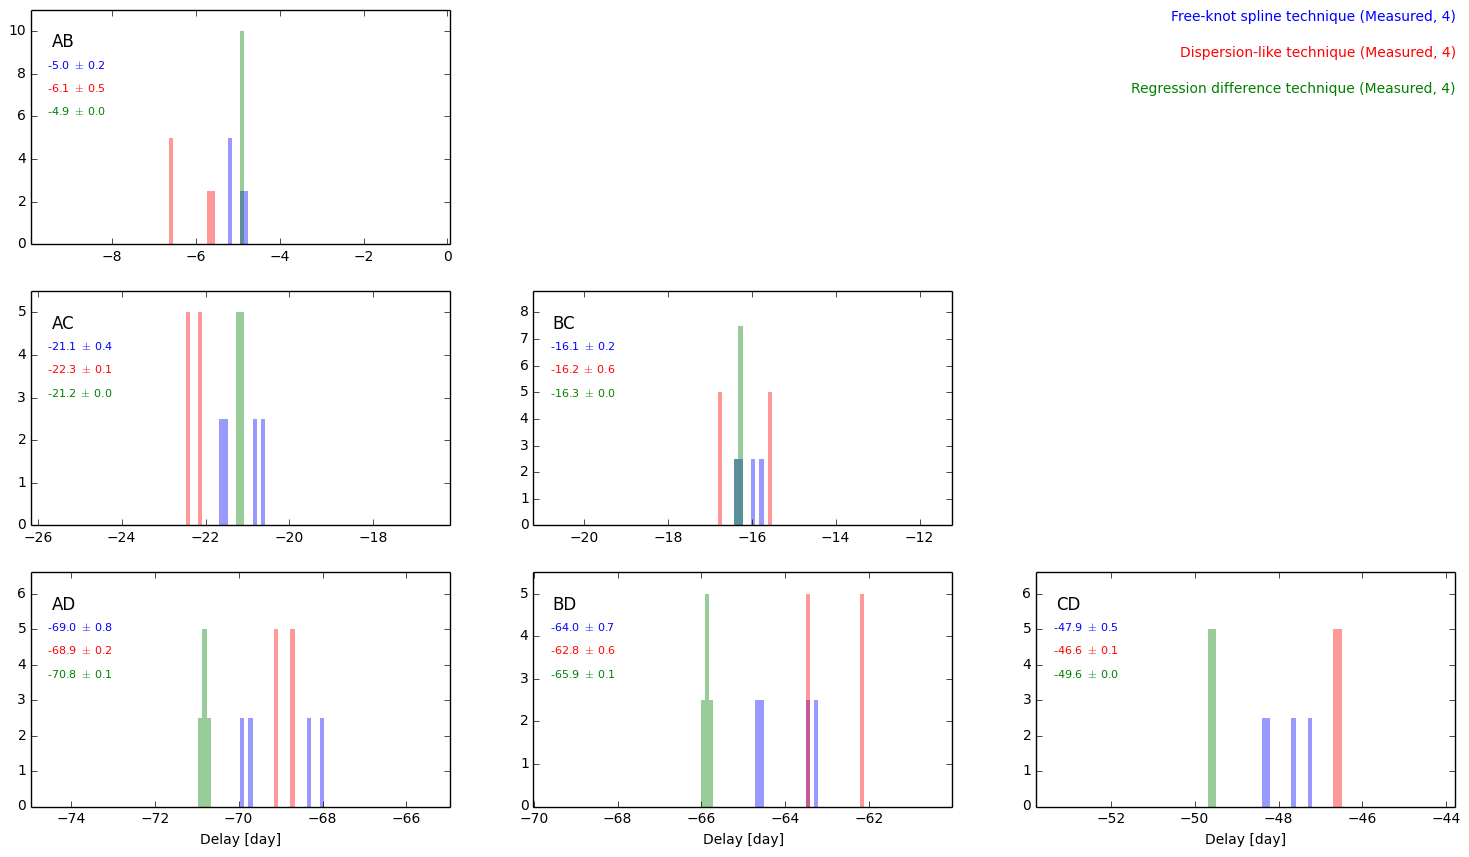

In [55]:
pycs.sim.plot.hists(dataresults, r=5.0, nbins=100, showqs=False,
        filename="fig_intrinsicvariance.pdf", dataout=True)

In [56]:
simresults = [        
    pycs.sim.run.collect("sims_mocks_opt_spl", "blue", "Free-knot spline technique"),
    pycs.sim.run.collect("sims_mocks_opt_disp", "red", "Dispersion-like technique"),
    pycs.sim.run.collect("sims_mocks_opt_regdiff", "green", "Regression difference technique")
]

Reading 4 runresult pickles...
OK, I have collected 4 runs from Free-knot spline technique
Reading 4 runresult pickles...
OK, I have collected 4 runs from Dispersion-like technique
Reading 4 runresult pickles...
OK, I have collected 4 runs from Regression difference technique


Wrote sims_mocks_opt_spl_errorbars.pkl
Wrote sims_mocks_opt_disp_errorbars.pkl
Wrote sims_mocks_opt_regdiff_errorbars.pkl


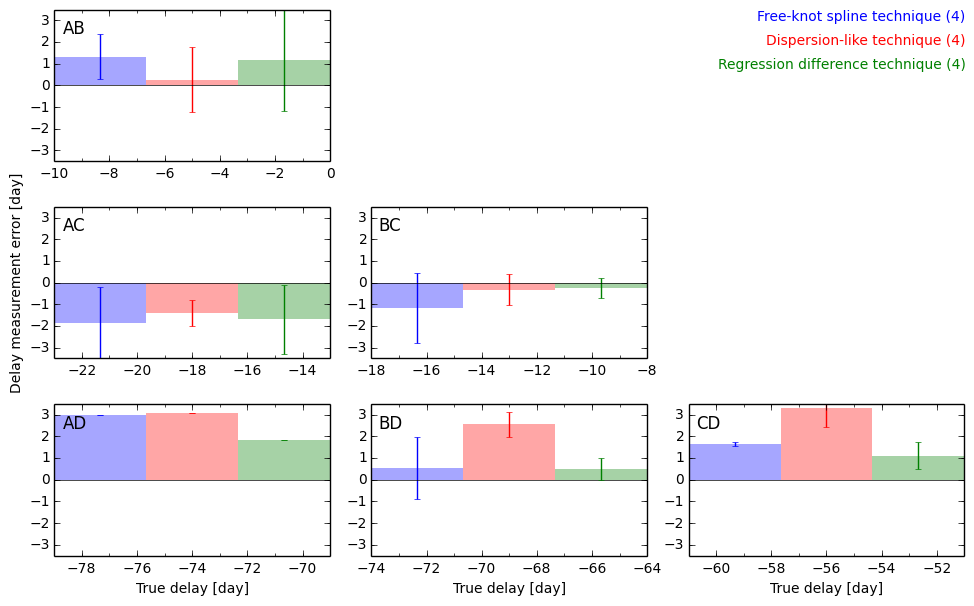

In [57]:
pycs.sim.plot.measvstrue(simresults, errorrange=3.5, r=5.0, nbins = 1, binclip=True, binclipr=20.0,
        plotpoints=False, filename="fig_measvstrue.pdf", dataout=True)

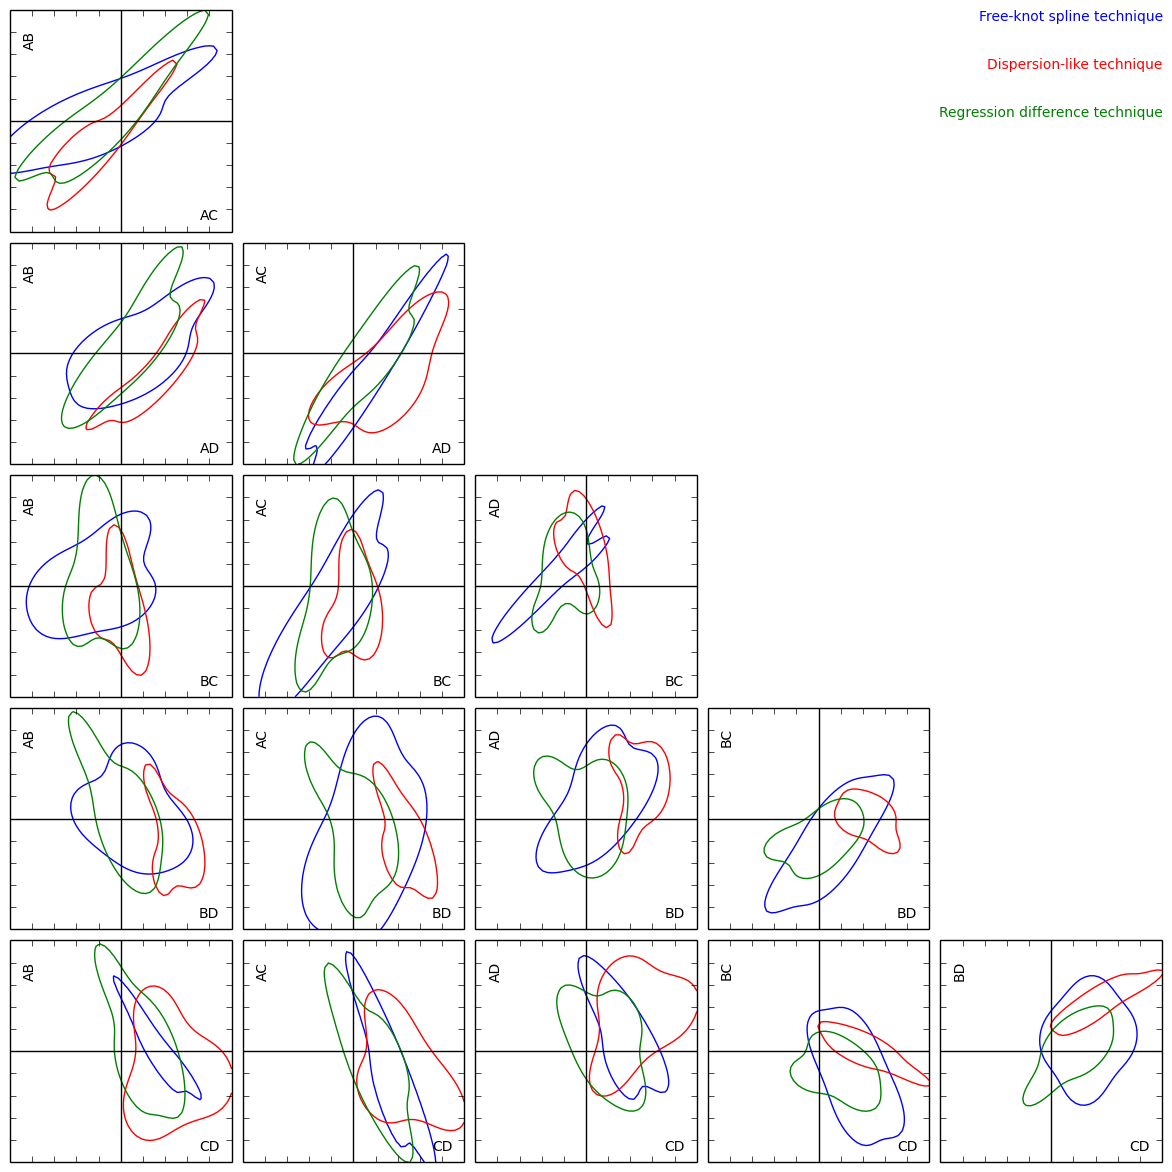

In [58]:
pycs.sim.plot.covplot(simresults, filename="fig_covplot.pdf")

In [59]:
disp = (pycs.gen.util.readpickle("sims_copies_opt_disp_delays.pkl"),
        pycs.gen.util.readpickle("sims_mocks_opt_disp_errorbars.pkl"))

regdiff = (pycs.gen.util.readpickle("sims_copies_opt_regdiff_delays.pkl"),
        pycs.gen.util.readpickle("sims_mocks_opt_regdiff_errorbars.pkl"))

spl = (pycs.gen.util.readpickle("sims_copies_opt_spl_delays.pkl"),
       pycs.gen.util.readpickle("sims_mocks_opt_spl_errorbars.pkl"))

Read sims_copies_opt_disp_delays.pkl
Read sims_mocks_opt_disp_errorbars.pkl
Read sims_copies_opt_regdiff_delays.pkl
Read sims_mocks_opt_regdiff_errorbars.pkl
Read sims_copies_opt_spl_delays.pkl
Read sims_mocks_opt_spl_errorbars.pkl


Our final plot! Again, over-writing ("fig_delays.pdf"), but summarizing the performance of the three methods.

Objects : A, B, C, D
Delays : Dispersion-like technique <-> Errors : Dispersion-like technique
Delays : Regression difference technique <-> Errors : Regression difference technique
Delays : Free-knot spline technique <-> Errors : Free-knot spline technique
################################################################################
           Delay AB
                    Dispersion-like technique :  -6.10 +/- 1.52 (1.50, 0.25)
              Regression difference technique :  -4.92 +/- 2.62 (2.34, 1.16)
                   Free-knot spline technique :  -5.03 +/- 1.69 (1.04, 1.33)
################################################################################
           Delay AC
                    Dispersion-like technique : -22.28 +/- 1.52 (0.60, 1.40)
              Regression difference technique : -21.20 +/- 2.33 (1.60, 1.69)
                   Free-knot spline technique : -21.14 +/- 2.48 (1.64, 1.85)
###############################################################################

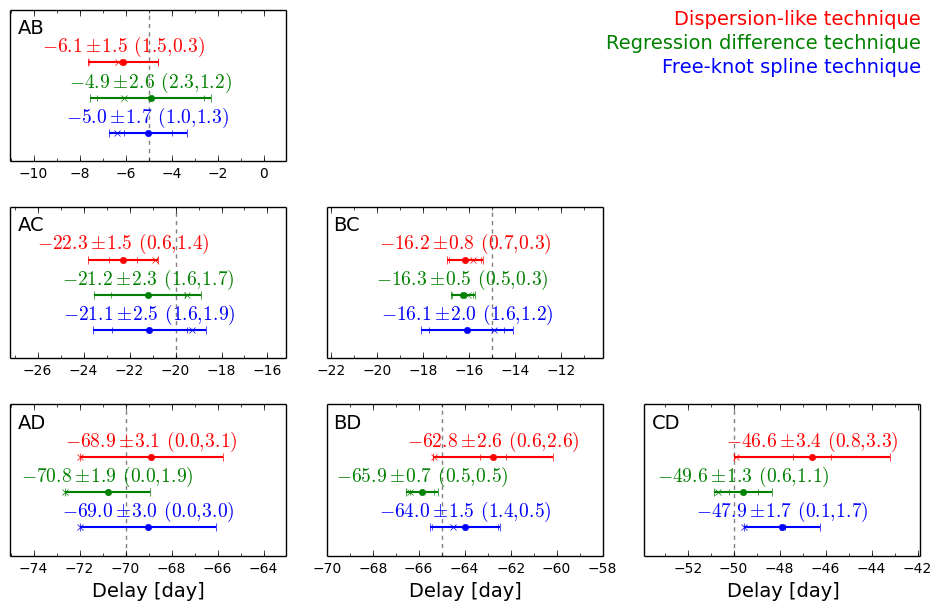

In [60]:
pycs.sim.plot.newdelayplot([disp, regdiff, spl], rplot=6.0, displaytext=True,
        filename = "fig_delays.pdf", refshifts=[{"colour":"gray", "shifts":(0, -5, -20, -70)}])